<a href="https://colab.research.google.com/github/ariellin10/Data-analysis/blob/main/Diamonds_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data source: Kaggle<br>
Data size: 53940 rows × 11 columns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('/content/drive/MyDrive/Colab csv/diamonds.csv')

In [3]:
df.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


確認各欄位型態、是否有空值，並刪除無意義欄位

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
#計算nan出現次數
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

視覺化數值特徵與預測目標之相關性，顏色越淺表示越相關<br>從中可發現重量(carat)與目標(price)之相關性最高，高達0.92

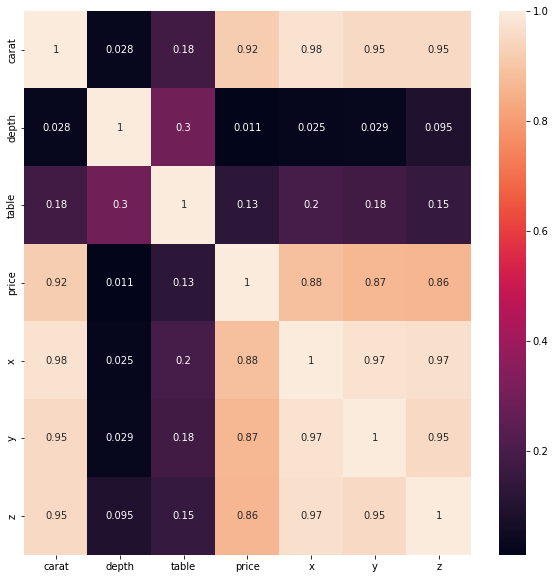

In [7]:
#熱力圖
correlation = df.corr()
plt.figure(1,figsize=(10,10))
sns.heatmap(correlation.abs(),annot=True)

將類別數值化、依優劣順序排序後代換到原dataframe<br>
再將其視覺化查看分佈狀況，可以發現就 cut & clarity而言，最低等級的數量比例非常低<br>
後天加工的cut最高等級的比例最高，將近40%<br>
而鑽石的天然條件color & clarity 則是中間等級之比例最高，也是約40%

In [8]:
cut_mp={'Fair':1, 'Good':2, 'Very Good':3 ,'Premium':4 ,'Ideal':5 }
color_mp={'J':1,'I':2,'H':3,'G':4,'F':5,'E':6,'D':7}
clarity_mp={'I1':1,'SI2':2,'SI1':3,'VS2':4,'VS1':5,'VVS2':6,'VVS1':7,'IF':8}

In [9]:
df['cut']=df['cut'].map(cut_mp)
df['color']=df['color'].map(color_mp)
df['clarity']=df['clarity'].map(clarity_mp)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


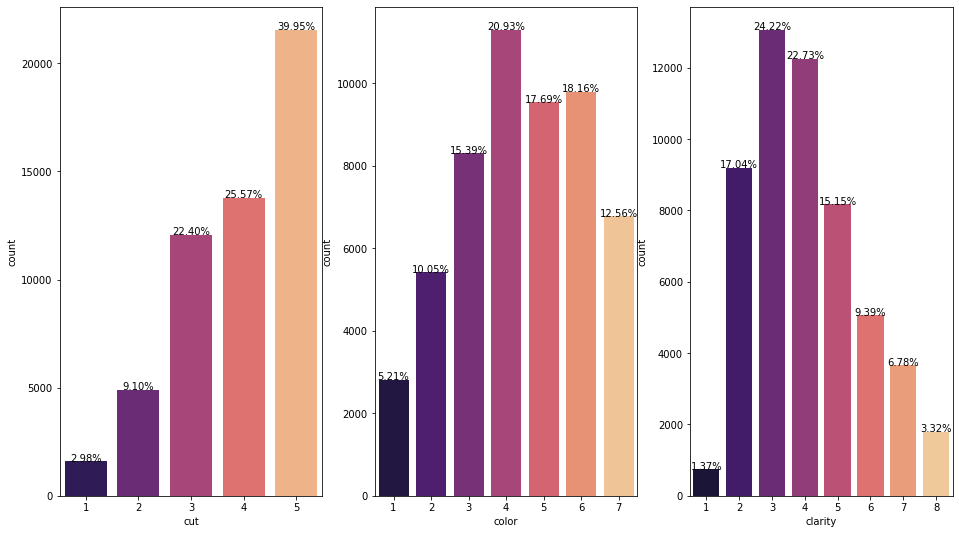

In [10]:
objs =['cut', 'color', 'clarity'] 

def pltCountplot(objs):
    fig, axis = plt.subplots(1,3, figsize=(16,9))  
    index = 0
    for i in range(3):
        ax = sns.countplot(objs[index], data=df, ax=axis[i],palette="magma")
       
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                     height + 3,
                     '{:1.2f}%'.format(height/len(df)*100),
                     ha="center") 
        index += 1
pltCountplot(objs)

In [11]:
df.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


迴歸模型對數值敏感故將之標準化

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['price'],axis=1))
y = scaler.fit_transform(df[['price']])

將資料以亂數切成訓練集80%、測試集20%，並讓切割結果固定不隨機

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=99)

宣告模型 KNN 與 LightGBM<br>並以MSE, MAE, R2_score為指標

In [14]:
kns = KNeighborsRegressor()
lgbm = LGBMRegressor(n_estimators = 300,  max_depth = 5, earning_rate= 1e-3)

In [15]:
kns.fit(X_train,y_train)
pred = kns.predict(X_test)
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
score = kns.score(X_test,y_test)
print('_____KNN_____\nMSE: {:.4f}\nMAE: {:.4f}\nR2_Score: {:.4f}'.format(mse,mae,score))

_____KNN_____
MSE: 0.0362
MAE: 0.0952
R2_Score: 0.9642


利用GridSearch找到最好的超參數Ｋ=7，結果MSE & MAE皆有所下降，但幅度不大

In [16]:
#訓練超參數 找出最好的Ｋ
ptrange = np.arange(1,11,2)
ptparams = ({'n_neighbors': ptrange})
gridsearch = GridSearchCV( kns ,ptparams,cv=10) 
gridsearch.fit(X_train,y_train)

kns.set_params(**gridsearch.best_params_)
kns.fit(X_train,y_train)
pred = kns.predict(X_test)
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
score = kns.score(X_test,y_test)
#gridsearch.best_params_, mse,rmse
print('_____KNN_____\ngridsearch＿best_params_K: {}\nMSE: {:.4f}\nMAE: {:.4f}\nR2_Score: {:.4f}'.format(gridsearch.best_params_,mse, mae, score))

_____KNN_____
gridsearch＿best_params_K: {'n_neighbors': 7}
MSE: 0.0354
MAE: 0.0943
R2_Score: 0.9649


使用LightGBM做預測，其MSE & RMSE明顯優於KNN之表現，但兩者之R2差異不大

In [17]:
lgbm.fit(X_train,y_train)
pred = lgbm.predict(X_test)
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
print('_____LGBM_____\nMSE: {:.4f}\nMAE: {:.4f}\nR2_Score: {:.4f}'.format(mse, mae, score))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


_____LGBM_____
MSE: 0.0183
MAE: 0.0691
R2_Score: 0.9649


本資料集非常簡單，不需要複雜的前處理就能達到很好的預測

整體而言，LightGBM與KNN預測表現不分軒輊，但前者之mse、mae均稍低一些